# Shape Measurement 102

This notebook has the first part of a small-ish tutorial on galaxy shape measurement. The goals of this tutorial are as follows

1. Become familiar with how weak lensing shear changes the shapes of objects.
2. Understand the basic principles behind `metacalibration`-based shape measurements.
3. Learn how to use `metadetection` and `ngmix` to measure the shapes of objects.

**Please do the 101 tutorial before doing this one!**

In order to run the code in this tutorial, you will need the following packages installed locally

 - `galsim`
 - `numpy`
 - `matplotlib`
 - `metadetect`
 - `ngmix`
 - `meds`
 - `joblib`
 - `schwimmbad`
 - `tqdm`
 - `joblib`
 - `fitsio`
 - `pyyaml`
 - `des-sxdes`
 
I suggest using `conda`. You can run the command

```
conda install galsim numpy matplotlib metadetect ngmix meds joblib schwimmbad tqdm fitsio pyyaml des-sxdes
```

in your environment to get things going.


## A. How does a weak lensing shear change the shape of an object?

Remember last time we learned about the moments of a surface brightness profile $I(x,y$

$$
\langle M_x\rangle = \frac{\int I(x,y) x}{\int I(x,y)}\\
\langle M_y\rangle = \frac{\int I(x,y) y}{\int I(x,y)}\\
\langle M_{xx}\rangle = \frac{\int I(x,y) (x - M_x)^2}{\int I(x,y)}\\
\langle M_{xy}\rangle = \frac{\int I(x,y) (x - M_x)(y-M_y)}{\int I(x,y)}\\
\langle M_{yy}\rangle = \frac{\int I(x,y) (y - M_y)^2}{\int I(x,y)}
$$

It turns out, one can compute specific combinations of these moments that are particularly sensitive to the shearing operation we discussed last time. These combinations are

$$
\langle M_{r}\rangle = M_{xx} + M_{yy}\\
\langle M_{+}\rangle = M_{xx} - M_{yy}\\
\langle M_{\times}\rangle = 2 M_{xy}\\
$$

which can then be combined into 

$$
e_1 = \frac{M_{+}}{M_{r}}\\
e_2 = \frac{M_{\times}}{M_{r}}\\
$$

I have not made the mathematical origin of these particular combinations clear at all, so this should be confusing. The key thing is to remember that one can compute moments and then use the equations above to compute the shape of the object $(e_1, e_2)$. Below we'll explore how shears change these moments.

### Exercise 1: How does it change?

In this exercise, we are going to draw objects with several different shears, make plots of them, and then explore how the object's moments change with shear. 

To do this, we'll want to use `galsim` to shear an object. This can be done as follows:

In [2]:
import galsim
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

obj = galsim.Gaussian(sigma=1)
sheared_obj = obj.shear(g1=0.01, g2=0.0)

We have called the `.shear` command which returns a new object that has been sheared by the amount given. If we print the underlying representation of this object out, we can see that `galsim` is applying a transformation to the original object, which hints at what a shear actually means:

In [3]:
print(repr(sheared_obj))

galsim.Transformation(galsim.Gaussian(sigma=1.0, flux=1.0, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), jac=[[1.0100505037878156, 0.0], [0.0, 0.9900495037128094]], offset=galsim.PositionD(x=0.0, y=0.0), flux_ratio=1.0, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05), propagate_gsparams=True)


With these preliminaries out of the way, do the following.

1. For each of the shears $(g_1, g_2) = \{(0, 0), (0.1, 0), (-0.1, 0), (0, 0.1), (0, -0.1)\}$, use `galsim` to make the sheared object and draw an image of it. Describe to yourself how the object changes in relationship to the shear you applied. Why might we have used $+$ and $\times$ when describing the moments above?
2. For a grid of shears on the 1-axis with $g_1$ going from -0.2 to 0.2 in steps of 0.025, measure the shapes `(e_1, e_2)` as defined above. Set $g_2=0$. What do you notice about the relationship between the shear and the shape when the shear is small?
3. Repeat 2 but with the roles of $g_1$ and $g_2$ swapped so that $g_1=0$ and the grid of shears is in $g_2$.
4. What is your guess for the generic relationship between shapes and shears?

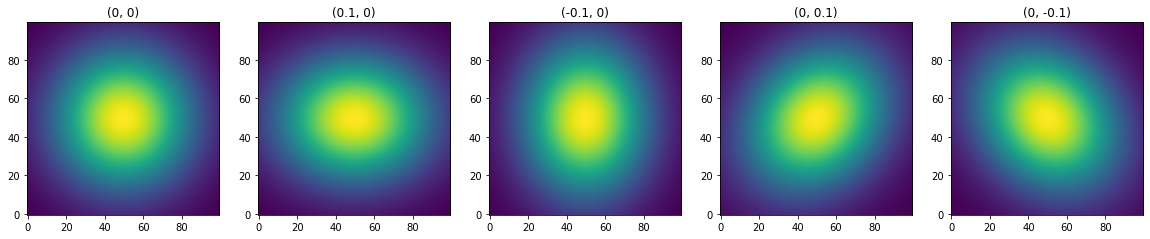

In [4]:
# do your work here

shear_list = [(0,0), (0.1,0), (-0.1,0), (0,0.1), (0,-0.1)]

fig, axes = plt.subplots(nrows=1, ncols=5,figsize=(20,5))

for i,shear in enumerate(shear_list):
    g1_, g2_ = shear
    sheared_obj = obj.shear(g1=g1_,g2=g2_) 
    im = sheared_obj.drawImage(scale=0.04,nx=100,ny=100)
    axes[i].imshow(im.array,origin='lower')
    axes[i].set_title(shear)
plt.show()

In [5]:
import numpy as np

def get_moments(im, x,y, verbose=False):
    
    # M = skimage.measure.moments_central(im,order=2)
        
    M_0 = np.sum(im)
    
    M_x = np.sum(x*im) / M_0
    M_y = np.sum(y*im) / M_0
    
    M_xx = np.sum((x-M_x)**2 * im) / M_0    
    M_yy = np.sum((y-M_y)**2 * im) / M_0    
    M_xy = np.sum((x-M_x) * (y-M_y) * im) / M_0    

    return((M_x,M_y,M_xx,M_xy,M_yy))

def get_elipticity(M_xx,M_xy,M_yy):
    
    M_r = M_xx + M_yy
    M_p = M_xx - M_yy
    M_x = 2*M_xy
    
    e1 = M_p / M_r
    e2 = M_x / M_r
    
    return (e1,e2)

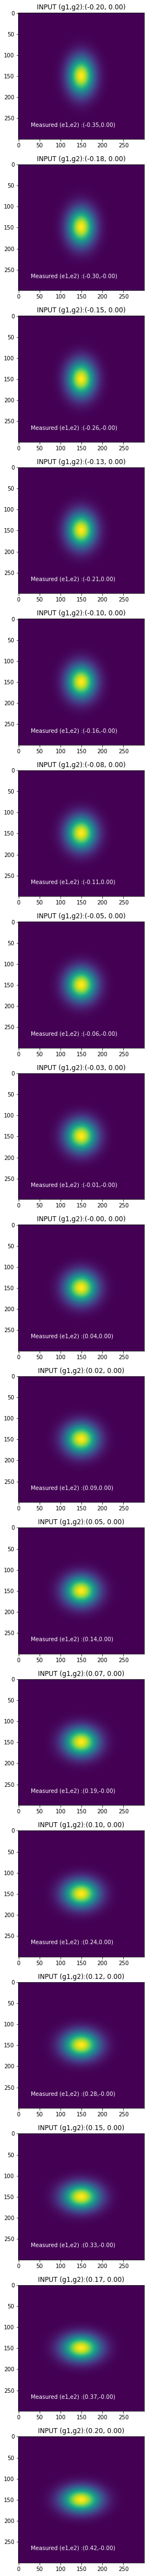

In [26]:
g1_range = np.arange(-0.2,0.201,0.025)
g2 = 0
shear_list = [(g1,g2) for g1 in g1_range]
e_list = []

fig, axes = plt.subplots(nrows=len(shear_list), ncols=1,figsize=(5, 5*len(shear_list)))

for i,shear in enumerate(shear_list):

    g1_, g2_ = shear
    sheared_obj = obj.shear(g1=g1_,g2=g2_) 
    im = sheared_obj.drawImage(scale=0.04,nx=300,ny=300)

    xmin_zero = im.bounds.xmin - 1
    xmax_zero = im.bounds.xmax - 1
    ymin_zero = im.bounds.ymin - 1
    ymax_zero = im.bounds.ymax - 1

    x, y = np.meshgrid(np.arange(xmin_zero, xmax_zero+1), np.arange(ymin_zero, ymax_zero+1))
    x, y = x*0.04, y*0.04
    
    M_x,M_y,M_xx,M_xy,M_yy = get_moments(im.array,x,y)
    e1,e2 = get_elipticity(M_xx,M_xy,M_yy)
    
    e_list.append((e1,e2))

    axes[i].imshow(im.array)
    axes[i].set_title(f"INPUT (g1,g2):({g1_:.02f}, {g2_:.02f})")
    axes[i].annotate(f"Measured (e1,e2) :({e1:.02f},{e2:.02f})", xy=(0.1,0.1),color='w', xycoords='axes fraction')
    
plt.show()

In [7]:
def get_x_y(im, scale):
    xmin_zero = im.bounds.xmin - 1
    xmax_zero = im.bounds.xmax - 1
    ymin_zero = im.bounds.ymin - 1
    ymax_zero = im.bounds.ymax - 1

    x, y = np.meshgrid(np.arange(xmin_zero, xmax_zero+1), np.arange(ymin_zero, ymax_zero+1))
    x, y = x*scale, y*scale

    return(x,y)

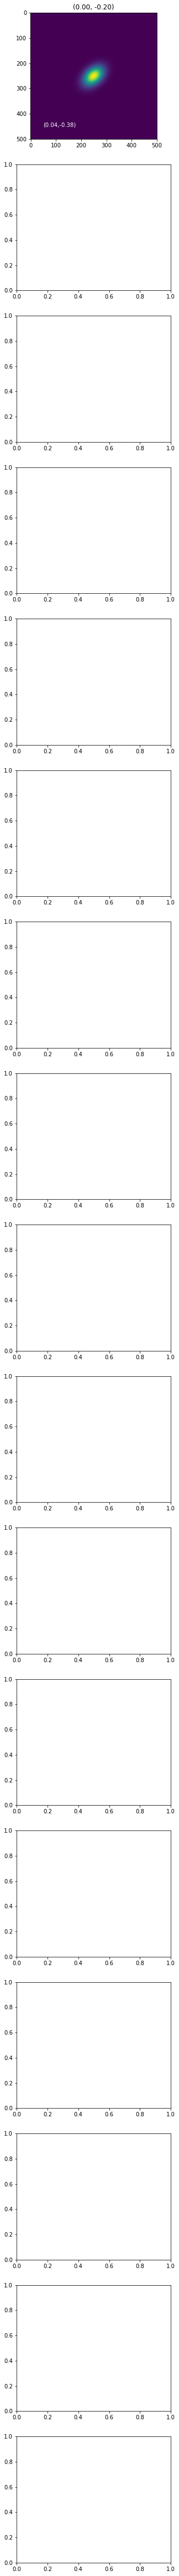

In [38]:
g1 = 0
g2_range = np.arange(-0.2,0.201,0.025)
shear_list = [(g1,g2) for g2 in g2_range]
e_list = []

fig, axes = plt.subplots(nrows=len(shear_list), ncols=1,figsize=(5, 5*len(shear_list)))

for i,shear in enumerate(shear_list):
    g1_, g2_ = shear
    sheared_obj = obj.shear(g1=g1_,g2=g2_) 
    
    SCALE = 0.04
    im = sheared_obj.drawImage(scale=SCALE,nx=501,ny=501,method="real_space")
    
    x,y = get_x_y(im,scale=SCALE)    
    
    M_x,M_y,M_xx,M_xy,M_yy = get_moments(im.array,x,y)
    e1,e2 = get_elipticity(M_xx,M_xy,M_yy)
    
    e_list.append((e1,e2))

    axes[i].imshow(im.array)
    axes[i].set_title(f"({g1_:.02f}, {g2_:.02f})")
    axes[i].annotate(f"({e1:.02f},{e2:.02f})", xy=(0.1,0.1),color='w', xycoords='axes fraction')
plt.show()

1. It's spin-2 coordiantes.
4. Shear $\approx$ elipticity

## B. Counterfactual Images and Metacalibration

In the last exercise, you should have discovered how the measured shape of an object changes as it is sheared by different amounts. In particular, for small or *weak* gravitational shears, we expect that

$$
e_i \approx e^{0} + R_i g_i
$$

where $R_i$ is called the *response*. The response is formally defined as a derivative $\left.de/dg\right.|_{g=0}$, but this is a detail that is not needed to complete this tutorial. They key bit of information here is that the response is the slope of the linear relationship between the observed shape and the underlying shear, for small shears.

### Exercise 2: Compute the response numerically with `galsim`!

In this exercise, we will use galsim to simulate the same object with different shears. Then by measuring the moments of those simulated profiles, we will estimate the response.

1. Using `galsim`, create a Gaussian object with `sigma=1` and a shear of `g1=0.01` and `g2=0`. Draw this object onto a grid of pixels with `scale=0.2` and measure the shape $(e_1, e_2)$.
2. Repeat 2 above but with `g1=-0.01` and `g2=0.0`. 
3. Combine the results from 1 and 2 to compute $R_1$ via a finite-difference derivative
$$
R_1 = \frac{e_1^{g1=+h} - e_1^{g1=-h}}{2h}
$$
This is called a central difference derivative is typically an accurate but efficient method for this kind of numerical work.

4. Do the same steps 1-3 but with the roles of the shears/shapes on the 1-axis swapped with those on the 2-axis. In other words, use shears with `g1=0`, `g2=+/-0.01` and compute $R_2$ by using a central difference derivative with $e_2$.
5. Now make the same object but apply the shear `g1=0.02` and `g2=0.0`. Measure its shape with the same pixel scale. Estimate the underlying shear applied to the object by inverting the linear relationship above
$$
g_{i}^{\rm obs} \approx e_i/R_i
$$
How close did you get?
# do your work here

obj = galsim.Gaussian(sigma=1)
sheared_obj = obj.shear(g1=0.01,g2=0)
im = sheared_obj.drawImage(scale=0.2)

x,y = get_x_y(im,scale=0.2)
M_x,M_y,M_xx,M_xy,M_yy = get_moments(im.array,x,y)
e1_p,e2 = get_elipticity(M_xx,M_xy,M_yy)
print(e1_p,e2)

In [9]:
# do your work here

obj = galsim.Gaussian(sigma=1)
sheared_obj = obj.shear(g1=0.01,g2=0)
im = sheared_obj.drawImage(scale=0.2)

x,y = get_x_y(im,scale=0.2)
M_x,M_y,M_xx,M_xy,M_yy = get_moments(im.array,x,y)
e1_p,e2 = get_elipticity(M_xx,M_xy,M_yy)
print(e1_p,e2)
# do your work here

obj = galsim.Gaussian(sigma=1)
sheared_obj = obj.shear(g1=-0.01,g2=0)
im = sheared_obj.drawImage(scale=0.2)

x,y = get_x_y(im,scale=0.2)
M_x,M_y,M_xx,M_xy,M_yy = get_moments(im.array,x,y)
e1_m,e2 = get_elipticity(M_xx,M_xy,M_yy)
print(e1_m,e2)
h = 0.01
R = (e1_p - e1_m)/(2*0.01)
print(R)

0.01993183164328242 -1.3155131149985821e-08
-0.019931748577871916 1.1355879422707645e-08
1.993179011057717


In [41]:
# do your work here
obj = galsim.Gaussian(sigma=1)

sheared_obj = obj.shear(g1=0.0,g2=0.01)
im = sheared_obj.drawImage(scale=0.2)
x,y = get_x_y(im,scale=0.2)
M_x,M_y,M_xx,M_xy,M_yy = get_moments(im.array,x,y)
e1,e2_p = get_elipticity(M_xx,M_xy,M_yy)
print(e1,e2_p)

sheared_obj = obj.shear(g1=0,g2=-0.01)
im = sheared_obj.drawImage(scale=0.2)

x,y = get_x_y(im,scale=0.2)
M_x,M_y,M_xx,M_xy,M_yy = get_moments(im.array,x,y)
e1,e2_m = get_elipticity(M_xx,M_xy,M_yy)
print(e1,e2_m)
h = 0.01
R = (e2_p - e2_m)/(2*0.01)
print(R)

4.074976225298521e-08 0.01992994857021451
4.6184897722792547e-08 -0.019930680722145055
1.993031464617978


In [11]:
# do your work here

obj = galsim.Gaussian(sigma=1)
obj = obj.shear(g1=0.02,g2=0)


sheared_obj = obj.shear(g1=0.01,g2=0)
im = sheared_obj.drawImage(scale=0.2)
x,y = get_x_y(im,scale=0.2)
M_x,M_y,M_xx,M_xy,M_yy = get_moments(im.array,x,y)
e1_p,e2 = get_elipticity(M_xx,M_xy,M_yy)
print(e1_p,e2)

sheared_obj = obj.shear(g1=-0.01,g2=0)
im = sheared_obj.drawImage(scale=0.2)
x,y = get_x_y(im,scale=0.2)
M_x,M_y,M_xx,M_xy,M_yy = get_moments(im.array,x,y)
e1_m,e2 = get_elipticity(M_xx,M_xy,M_yy)
print(e1_m,e2)
h = 0.01
R1 = (e1_p - e1_m)/(2*0.01)
print(f"{R1=}")

sheared_obj = obj.shear(g1=0,g2=0.01)
x,y = get_x_y(im,scale=0.2)
M_x,M_y,M_xx,M_xy,M_yy = get_moments(im.array,x,y)
e1,e2_p = get_elipticity(M_xx,M_xy,M_yy)
print(e1,e2_p)
# do your work here

sheared_obj = obj.shear(g1=0,g2=-0.01)
im = sheared_obj.drawImage(scale=0.2)

x,y = get_x_y(im,scale=0.2)
M_x,M_y,M_xx,M_xy,M_yy = get_moments(im.array,x,y)
e1,e2_m = get_elipticity(M_xx,M_xy,M_yy)
print(e1,e2_m)
h = 0.01
R2 = (e2_p - e2_m)/(2*0.01)
print(f"{R2=}")

print(f"g1_hat = {e1/R1:0.2f}, g2_hat = {e2/R2:0.2f}")
print(f"Error in the shear estimator is {e1/R1 - 0.02}")

0.05973535244212254 -1.378363870946422e-07
0.019935677468184015 -7.363258139864708e-09
R1=1.989983748696926
0.019935677468184015 -7.363258139864708e-09
0.039839309959161 -0.019931155841112578
R2=0.996557423892722
g1_hat = 0.02, g2_hat = -0.00
Error in the shear estimator is 1.991724065507003e-05


## C. Metadetection/Metacalibration in real data with `ngmix`

Congrats! By completing exercise 2 of this tutorial you have coded up an extremely simple, but non-trivial form of the `metacalibration` weak lensing shape measurement technique!

Moving from here to applying this to real observed galaxies involves a lot of complications. Namely

1. We don't know the true underlying surface brightness profile of real galaxies. Thus we cannot directly compute the response from the unsheared surface brightness profile like we did above.
2. Real galaxies are observed through telescopes and we need to account for this effect when computing the response.
3. Images of real galaxies have noise in them. If we take an image with noise in it and shear the image, we will get correlated noise which can cause bias in our shape measurements.

The solutions to these problems are the subject of years of research, so I'll give you the answers.

1. Instead of using the true surface brightness profile of an object, we use the observed image of the object itself. We can do this because the shear applied by nature is small, so that the difference between the response computed using the observed object and that using the true object is even smaller. This process generates a *counter-factual* image of the object at another shear, hence the title above.
2. We measure the PSF of the telescope and atmosphere using stars around the galaxy. We can then use this observed PSF to remove these effects via a process called deconvolution. This process cannot fully recover the galaxy as it would look without the telescope and atmosphere, but it can remove enough of these effects for our purposes.
3. We can apply special noise corrections to our images which account for the correlated noise. The details of this process are unimportant except to say that if we don't we see 5% to 10% biases our measurements.

All of these algorithms have been coded up into two packages, `metadetect` and `ngmix`. These are the main tools you will be using. The next exercise introduces them to you and generates the first kinds of simulations you'll run to test shape measurement.

### Exercise 3: Making Sims w/ `ngmix` and `galsim`

In this exercise, we will write a function to create a simple simulation of a single object using `ngmix` and `galsim`. Your goal tasks are to

1. Fill in the parts of the function below to make the sim.
2. Run the simulation with different shears and different psf sizes, measuring the output shape using the moments code above. Try psf sizes from 0.8 to 1.2 in steps of 0.1. What is the relationship between the slope of output shape vs input shape and the size of the PSF?

The simulation code will output an `ngmix.Observation` object. You can read more about them in the docs: https://github.com/esheldon/ngmix/blob/master/ngmix/observation.py#L66. Here is a short set of things you can do:

```
# get the image in this observation as a numpy array
obs.image 

# get the image of the PSF as a numpy array
obs.psf.image
```

Note that these objects are read only, so you cannot modify the images etc once they are made without special syntax.

In [12]:
import ngmix
import numpy as np


def sim_func(*, g1, g2, seed, psf_fwhm):
    # this is an RNG you can use to draw random numbers as needed
    # always use this RNG and not np.random directly
    # doing this makes sure the code is reproducible
    rng = np.random.RandomState(seed=seed)

    # make an Exponential object in galsim with a half light radius of 0.5
    gal = galsim.Exponential(half_light_radius=0.5)

    # make a Gaussian object in galsim with a fwhm of `psf_fwhm`
    psf = galsim.Gaussian(fwhm=psf_fwhm)

    # apply the input shear `g1`, `g2` to the galaxy `gal`
    sheared_gal = gal.shear(g1=g1, g2=g2)

    # here we are going to apply a random shift to the object's center
    dx, dy = 2.0 * (rng.uniform(size=2) - 0.5) * 0.2
    sheared_gal = sheared_gal.shift(dx, dy)

    # convolve the sheared galaxy with the psf
    obj = galsim.Convolve(sheared_gal, psf)

    # render the object and the PSF on odd sized images of 53 pixels on a side with
    # a pixel scale of 0.2
    obj_im = obj.drawImage(scale=0.2, nx=53, ny=53)
    psf_im = psf.drawImage(scale=0.2, nx=53, ny=53)

    # now we are going to add noise to the object image and setup the ngmix data
    cen = (53 - 1) / 2
    nse_sd = 1e-5
    nse = rng.normal(size=obj_im.array.shape, scale=nse_sd)
    nse_im = rng.normal(size=obj_im.array.shape, scale=nse_sd)
    jac = ngmix.jacobian.DiagonalJacobian(scale=0.2,
                                          row=cen + dy / 0.2,
                                          col=cen + dx / 0.2)
    psf_jac = ngmix.jacobian.DiagonalJacobian(scale=0.2, row=cen, col=cen)

    # Transformation between pixel and tangent uv coordinate. It has off diag terms if CCD is rotated.
    # in real data we care about off diag terms 

    # we have to add a little noise to the PSf to make things stable
    target_psf_s2n = 500.0
    target_psf_noise = np.sqrt(np.sum(psf_im.array**2)) / target_psf_s2n
    psf_obs = ngmix.Observation(
        image=psf_im.array,
        weight=np.ones_like(psf_im.array) / target_psf_noise**2,
        jacobian=psf_jac,
    )

    # here we build the final observation
    obj_obs = ngmix.Observation(
        image=obj_im.array + nse,
        noise=nse_im,
        weight=np.ones_like(nse_im) / nse_sd**2,
        jacobian=psf_jac,
        bmask=np.zeros_like(nse_im, dtype=np.int32),
        ormask=np.zeros_like(nse_im, dtype=np.int32),
        psf=psf_obs,
    )

    return obj_obs

In [ ]:
# start add noise to the image
# what is the relation between error in m vs the noise level applied
# pixel noise vs shape noise (level of 0.2)

# read Dodelson: 1. overview, section 2,4, read section 6,7,8 + magnefication, possibly 9

In [13]:
# do your work here
obs_list_psf = []
obs_list_g1 = []

psf_range = np.arange(0.8,1.21,0.1)
g1_range = np.arange(0.01,0.1,0.01)

for psf in psf_range:
    obs_list_psf.append(sim_func(g1=0.01,g2=0,seed=123,psf_fwhm=psf))

for g1 in g1_range:
    obs_list_g1.append(sim_func(g1=g1,g2=0,seed=123,psf_fwhm=0.8))

In [14]:
def get_shapes_for_ngmix(obs_array):

    x, y = np.meshgrid(np.arange(0, 52+1), np.arange(0, 52+1))
    x, y = x*0.2, y*0.2 

    M_x,M_y,M_xx,M_xy,M_yy = get_moments(obs_array,x,y)
    e1,e2 = get_elipticity(M_xx,M_xy,M_yy)
    
    return(e1,e2)

In [15]:
shape_list_g1 = [get_shapes_for_ngmix(obs.image) for obs in obs_list_g1]
shape_list_psf = [get_shapes_for_ngmix(obs.image) for obs in obs_list_psf]

Text(0, 0.5, 'e2')

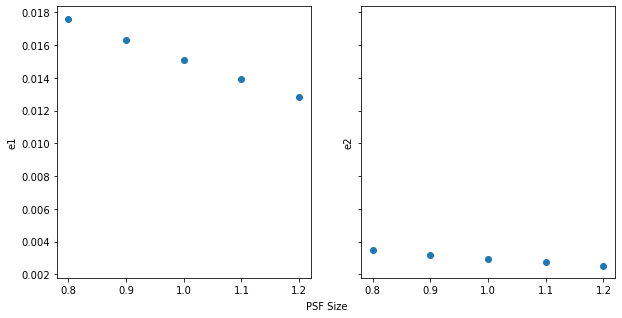

In [16]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5),sharey=True)
axes[0].scatter(psf_range,np.array([e1 for (e1,e2) in shape_list_psf]))
axes[1].scatter(psf_range,np.array([e2 for (e1,e2) in shape_list_psf]))
fig.text(0.5, 0.04, 'PSF Size', ha='center')
axes[0].set_ylabel("e1")
axes[1].set_ylabel("e2")

Assume the input shape is constant, the slope of input shape vs output shape is linear in PSF size

Text(0, 0.5, 'e2')

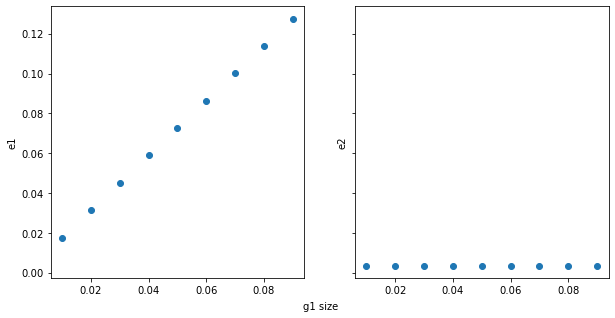

In [17]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5),sharey=True)
axes[0].scatter(g1_range,np.array([e1 for (e1,e2) in shape_list_g1]))
axes[1].scatter(g1_range,np.array([e2 for (e1,e2) in shape_list_g1]))
fig.text(0.5, 0.04, 'g1 size', ha='center')
axes[0].set_ylabel("e1")
axes[1].set_ylabel("e2")

### Exercise 4: Run metadetect!

In this exercise you will run metadetection for real! Yay! Before we do that, we need to understand a few things about the results. We are aiming to measure the shear and are using the estimate $g^{obs}$ as defined above. There is a standard way to characterize the bias in this estimate, which in our notation is

$$
g^{obs} = (1+m)g^{true} + c
$$

Here $m$ is called the *multiplicative bias* and is the fractional error in our shear estimate. The quantity $c$ is called the additive bias and denotes any mean bias in our shear estimate. For metadetect, we expect 

$$
m\approx 0.4\times10^{-3}\\
c\approx 0
$$

Due to measurement noise in the simulations, we usually check that these conditions are true to within the $3\sigma$ error bar.

In the python source file `mdet_meas_tools.py`, I have put a bunch of code that you will use to run the simulation you made above through metadetection. The main functions to worry about are

 - `run_mdet_sims` - used to make the measurements
 - `write_sim_data` - used to write the simulation data to disk
 - `read_sim_data` - used to read the simulation data from disk
 - `estimate_m_and_c` - used to estimate $m$ and $c$ from a sim
 
Read the doc strings on these functions for instructions on how to use them. Note that you need to pass a python dictionary for the `sim_kwargs` input and it should have the form `{"psf_fwhm": 0.9}`.

Do the following:

1. Use `run_mdet_sims` to run metadetection on your sim and verify that $m$ and $c$ meet the requirements above.
2. Use the utilities to write your data to and then read your data from disk.
3. Run your data through `estimate_m_and_c` and confirm you get the same answer as in 1.

In [18]:
# do your work here!
import mdet_meas_tools as mmt

In [19]:
pdata,mdata = mmt.run_mdet_sims(sim_func=sim_func,sim_kwargs={'psf_fwhm':0.9},seed=123,n_sims=10)

    # of sims: 10
    noise cancel m   :  0.387014 +/-  1.474726 [1e-3, 3-sigma]
    noise cancel c   :  3.348672 +/-  24.498422 [1e-5, 3-sigma]


In [20]:
mmt.write_sim_data('.sim_data',pdata,mdata)
pdata_,mdata_ = mmt.read_sim_data('.sim_data')

In [21]:
res = mmt.estimate_m_and_c(pdata_,mdata_)